# Notebook for clustering SalishSeaCast data - PRODIGY Field School May 2024

## We will use the sklearn-som package. In order to install it, follow the steps below:


#### 1) Extract the rar file provided to a directory (some-dir)
#### 2) On the python terminal, type the following command: `pip install C:/some-dir/sklearn_som-1.1.0-py3-none-any.whl`

## Or run on your terminal `pip install sklearn-som` if the internet connection is stable

## What is clustering?

### From this
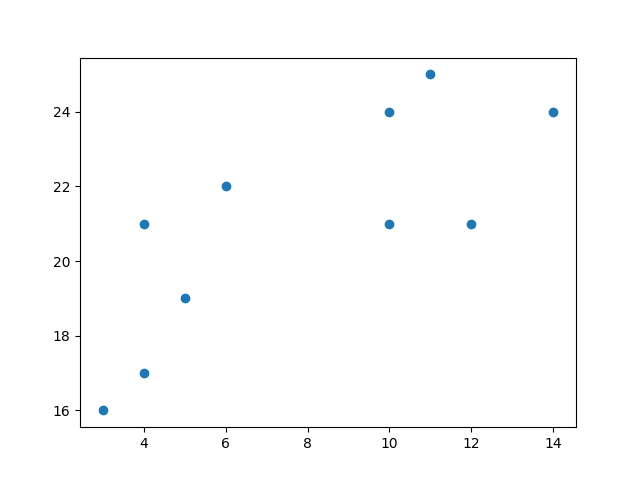

### To this
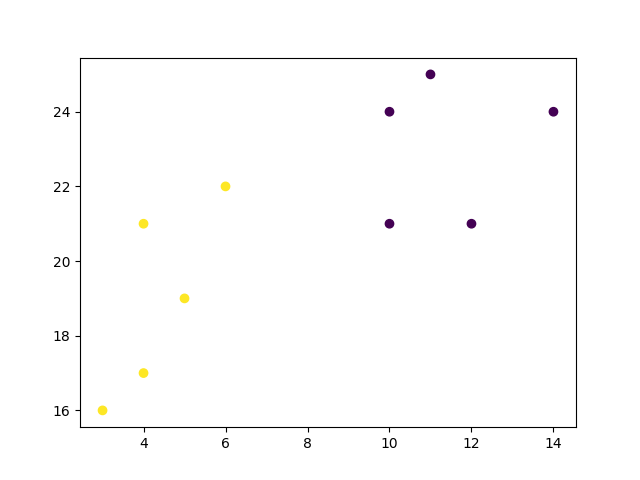

## Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn_som.som import SOM


## File Reading

In [348]:
# The location of the file - change it to the directory you extracted it
ds = xr.open_dataset('/data/ibougoudis/MOAD/files/field_school.nc')


## Opening the dataset and its variables

<xarray.Dataset> Size: 172MB
Dimensions:       (time_counter: 1, y: 898, x: 398, deptht: 40)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 8B 2022-03-31T12:00:00
  * y             (y) int64 7kB 0 1 2 3 4 5 6 7 ... 891 892 893 894 895 896 897
  * x             (x) int64 3kB 0 1 2 3 4 5 6 7 ... 391 392 393 394 395 396 397
  * deptht        (deptht) float32 160B 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
Data variables:
    Temperature   (time_counter, deptht, y, x) float32 57MB ...
    Salinity      (time_counter, deptht, y, x) float32 57MB ...
    Diatoms       (time_counter, deptht, y, x) float32 57MB ...


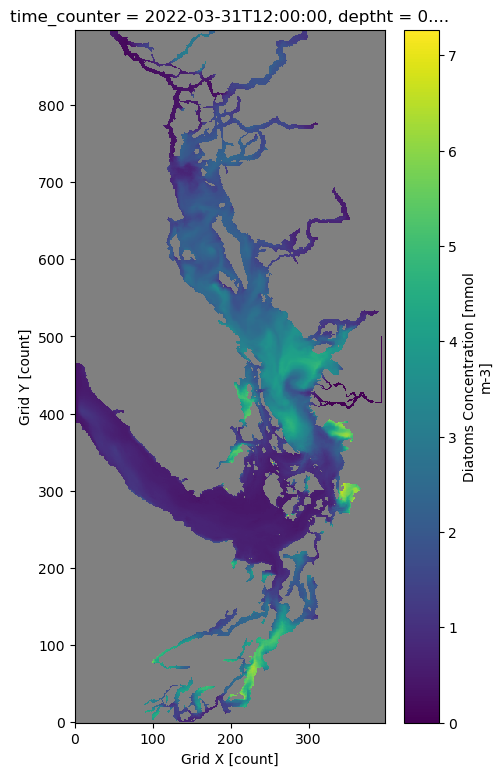

In [349]:
# Printing the features of the dataset
print(ds)

# Keeping the quantities of interest in separate variables
temperature = ds['Temperature']
salinity = ds['Salinity']
diatoms = ds['Diatoms']

# Defining y and x regions
y_min = 0
y_max = len(ds.y)

x_min = 0
x_max = len(ds.x)

# Plotting diatoms for the first depth and for the whole region
cmap = plt.get_cmap()
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 1, figsize=(5, 9))
diatoms[0,0,y_min:y_max, x_min:x_max].plot(cmap=cmap)


## Clustering - single variable

In [350]:
def clustering_single(inputs, m, n):

    inputs0 = inputs # We need the dimensions of the original inputs variable    

    # Pre processing 

        # Making the variable flat
    inputs = np.ravel(inputs)   

        # Finding nans
    indx = np.where(~np.isnan(inputs))
    inputs2 = inputs[indx] # We need the original inputs variable

    inputs2 = inputs2.reshape(len(inputs2),1)

        # Normalization of the values
    inputs2 = (inputs2 - inputs2.min(axis=0)) / (inputs2.max(axis=0) - inputs2.min(axis=0))

    # SOM
    som = SOM(m, n, dim= inputs2[0].size) # m, n are the dimensions of the produced map, dim is the amount of features (variables) of the inputs
    predictions = som.fit_predict(inputs2) # Training 

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs.size,np.nan) # We need the shape of the original inputs variable
    indx2[indx] = predictions
    clusters = np.reshape(indx2,(len(inputs0.y),len(inputs0.x)))

    # Preparation of the dataarray 
    clusters= xr.DataArray(clusters,
        coords = {'y': inputs0.y, 'x': inputs0.x},
        dims = ['y','x'],
        attrs=dict(description="Clusters of the performed self organizing map algorithm",
        long_name ="Cluster",
        units="counts"))
    
    return (clusters, unique, counts)


## Clustering - multiple variables

In [351]:
def clustering_multiple(inputs, m, n):

    inputs0 = inputs # We need the dimensions of the original inputs variable    
    inputs = inputs.to_numpy()

    # Pre processing 

        # Making the variables flat
    inputs = np.reshape(inputs,(inputs.shape[0], inputs.shape[1] * inputs.shape[2])) 

        # Finding nans
    indx = np.where(~np.isnan(inputs).any(axis=0))
    inputs2 = inputs[:,indx[0]] # We need the original inputs variable

    inputs2 = inputs2.transpose()

        # Normalization of the values
    inputs2 = (inputs2 - inputs2.min(axis=0)) / (inputs2.max(axis=0) - inputs2.min(axis=0))

    # SOM
    som = SOM(m, n, dim= inputs2[0,:].size) # m, n are the dimensions of the produced map, dim is the amount of features (variables) of the inputs
    predictions = som.fit_predict(inputs2) # Training 

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan) # We need the shape of the original inputs variable
    indx2[indx[0]] = predictions
    clusters = np.reshape(indx2,(inputs0.shape[1],inputs0.shape[2]))

    # Preparation of the dataarray 
    clusters= xr.DataArray(clusters,
        coords = {'y': np.arange(0,inputs0.shape[1]), 'x': np.arange(0,inputs0.shape[2])},
        dims = ['y','x'],
        attrs=dict(description="Clusters of the performed self organizing map algorithm",
        long_name ="Cluster",
        units="counts"))
    
    return (clusters, unique, counts)


## Plotting - single variable

In [352]:
def plotting_single(clusters, inputs, unique):

    fig, ax = plt.subplots(ncols=2, figsize=(10, 6))

    cmap = plt.get_cmap('tab20', unique.max()+1)
    cmap.set_bad('gray')
    clus = clusters.plot(ax=ax[0], cmap=cmap, vmin = unique.min(), vmax = unique.max()+1, add_colorbar=False)

    cbar = fig.colorbar(clus, ticks = unique+0.5) 
    cbar.set_ticklabels(unique+1)
    cbar.set_label('Clusters [count]')

    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.9, 
        top=0.9, 
        wspace=0.4, 
        hspace=0.4)
        
    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')

    inputs.plot(ax=ax[1], cmap=cmap)

    ax[0].title.set_text('')
    ax[1].title.set_text('')

    ax[0].axis('off')
    ax[1].axis('off')
    

## Plotting - multiple variables

In [353]:
def plotting_multiple(clusters, inputs, unique):

    fig, ax = plt.subplots(2,2, figsize=(10, 15))

    cmap = plt.get_cmap('tab20', unique.max()+1)
    cmap.set_bad('gray')
    clus = clusters.plot(ax=ax[0,0], cmap=cmap, vmin = unique.min(), vmax = unique.max()+1, add_colorbar=False)

    cbar = fig.colorbar(clus, ticks = unique+0.5) 
    cbar.set_ticklabels(unique+1)
    cbar.set_label('Clusters [count]')

    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.9, 
        top=0.95, 
        wspace=0.25, 
        hspace=0.15)
        
    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')

    inputs[0].plot(ax=ax[0,1], cmap=cmap)
    inputs[1].plot(ax=ax[1,0], cmap=cmap, cbar_kwargs={'label': 'Reference Salinity [g kg-1]'})

    ax[0,0].title.set_text('')
    ax[0,1].title.set_text('')
    ax[1,0].title.set_text('')

    ax[1,1].axis('off')


## Printing

In [354]:
def printing(unique, counts):

    for i in  range(0, len(unique)):
        
        print('The amount of grid boxes for cluster ' + str(unique[i]+1), ' is ' + str(counts[i]))
        

## Clustering with one variable as input

The amount of grid boxes for cluster 1  is 27246
The amount of grid boxes for cluster 2  is 10161
The amount of grid boxes for cluster 3  is 19927
The amount of grid boxes for cluster 4  is 11746
The amount of grid boxes for cluster 5  is 12303


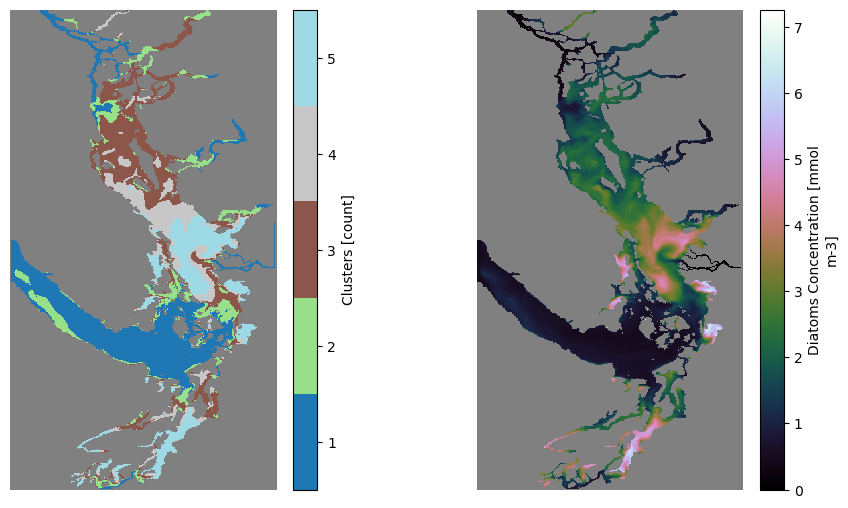

In [361]:
# Dimensions of the self organizing map
m = 5
n = 1

# Defining the inputs
inputs = diatoms[0, 0, y_min:y_max, x_min:x_max] # Clustering at the 0th depth
clusters, unique, counts = clustering_single(inputs, m, n)

printing(unique, counts)

plotting_single(clusters, inputs, unique)


## Clustering with two variable as inputs

The amount of grid boxes for cluster 1  is 12457
The amount of grid boxes for cluster 2  is 12306
The amount of grid boxes for cluster 3  is 21855
The amount of grid boxes for cluster 4  is 6847
The amount of grid boxes for cluster 5  is 16206


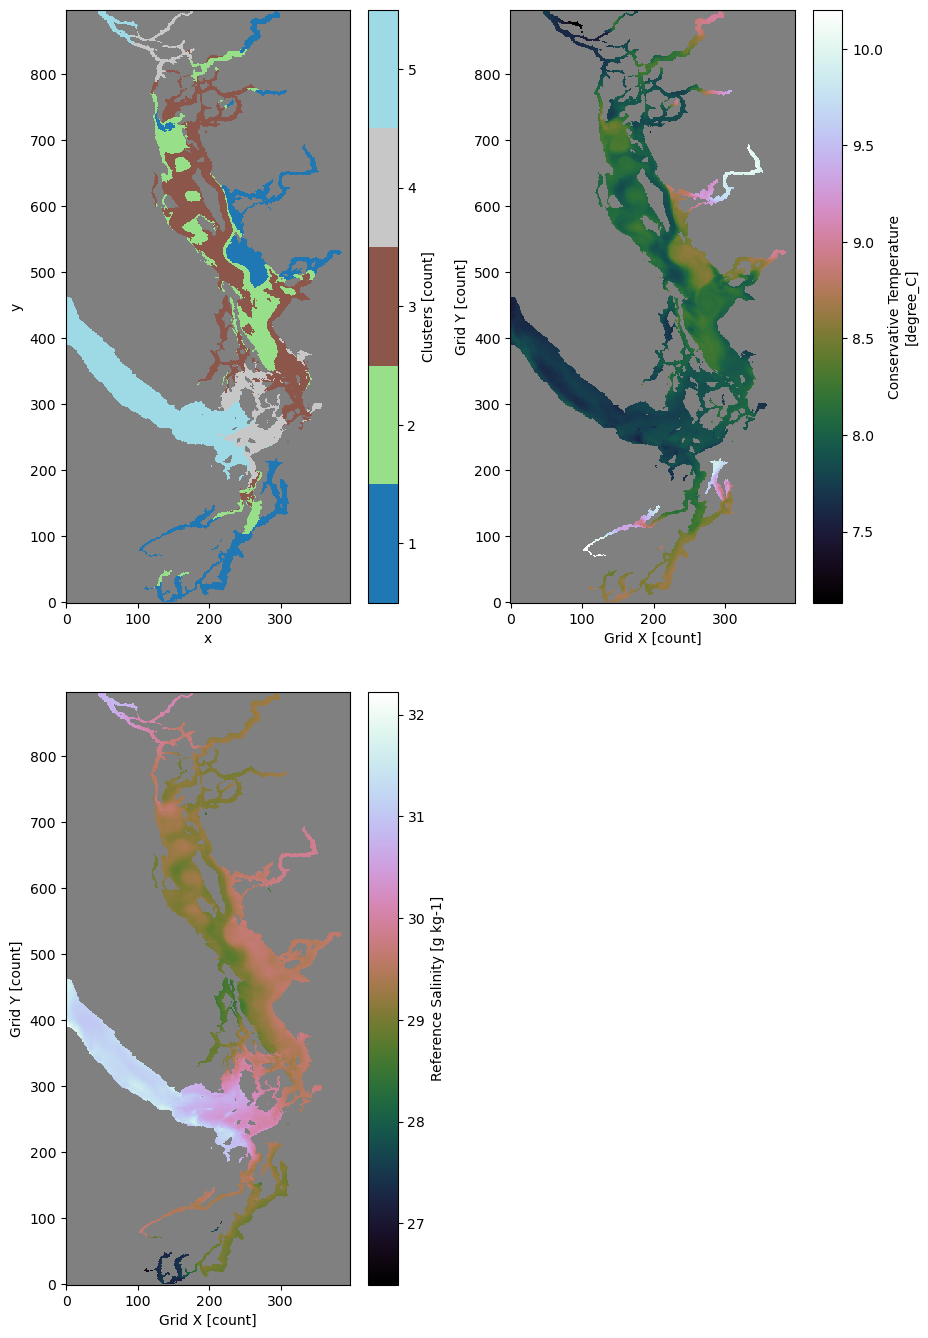

In [360]:
# Dimensions of the self organizing map
m = 5
n = 1

# Defining the inputs
inputs = xr.concat([temperature[0, 20, y_min:y_max, x_min:x_max], salinity[0, 20, y_min:y_max, x_min:x_max]], dim='time_counter') # Clustering at the 20th depth
clusters, unique, counts = clustering_multiple(inputs, m, n)

printing(unique, counts)

plotting_multiple(clusters, inputs, unique)
